In [1]:
#based on
#https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
#https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line

#Transform Time Series to Scale

In [1]:
DATA_DIR = "/home/ubuntu/fastai/data/"

In [20]:
# load and plot dataset
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime as pddatetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


from datetime import datetime

In [21]:
# load dataset
def parser(x):
    return pddatetime.strptime('190'+x, '%Y-%m')


In [4]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df


In [5]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)


In [6]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


In [7]:
# scale train and test data to [-1, 1]
def scale(train, test):
    #does this guarantee test_scaled will be within -1, 1 range?
    #since scale is set from train data not test.
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


In [8]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


In [9]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    #NB: The batch_size must be set to 1. This is because it must be a factor of the size of the training and test datasets.
    #look at this when fit_lstm is called.
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model


In [10]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [12]:
series = read_csv(DATA_DIR+'shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
print (series.shape)

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
(36,)


In [37]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
#
print ("raw_values:", type(raw_values), raw_values.shape)
print ("diff_values:", type(diff_values), diff_values.shape)

#we now have 1 less row since we calculated difference between current and immediately previous value.
#nbb: extra work would be required to create data over multiple time periods back.

raw_values: <class 'numpy.ndarray'> (36,)
diff_values: <class 'pandas.core.series.Series'> (35,)


In [38]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print ("supervised_values:", type(supervised_values), supervised_values.shape)
#nb: we now have 2 columns since we are comparing sequence of data over a time period.

supervised_values: <class 'numpy.ndarray'> (35, 2)


In [39]:
# split data into train and test-sets
train = supervised_values[0:-12]
test  = supervised_values[-12:]


In [34]:
print ("train:", train.shape)
print ("test:", test.shape)
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
#def scale : scale train and test data to [-1, 1]
print ("train_scaled:", train_scaled.shape, type(train_scaled))
print ("test_scaled:", test_scaled.shape, type(test_scaled))
print ("test_scaled:", numpy.amin(test_scaled), numpy.amax(test_scaled))
print ("train_scaled:", numpy.amin(train_scaled), numpy.amax(train_scaled))

train: (23, 2)
test: (12, 2)
train_scaled: (23, 2) <class 'numpy.ndarray'>
test_scaled: (12, 2) <class 'numpy.ndarray'>
test_scaled: -1.26760183437 1.32802805503
train_scaled: -1.0 1.0


In [42]:
startTime= datetime.now()
print ("startTime:", startTime)

# fit the model
#def fit_lstm(train, batch_size, nb_epoch, neurons):
#batch_input_shape=(batch_size, X.shape[1], X.shape[2])
#nb: batch_size must be a factor of both the training and test datasets. 
# lazy/easiest option is set batch_size = 1

#lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


startTime: 2018-01-11 10:47:19.967938
Time elapsed (hh:mm:ss.ms) 0:03:00.192593


In [43]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1)                    12        
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [44]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#nb: select column 0 of train_scaled and reshape to suit input shape required for the lstm model.

print ("train_reshaped:", type(train_reshaped), train_reshaped.shape)


train_reshaped: <class 'numpy.ndarray'> (23, 1, 1)


In [45]:
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.23018618],
       [ 0.3132689 ],
       [-0.26314092],
       [ 0.27475718],
       [-0.39855021],
       [ 0.07129454],
       [-0.5185557 ],
       [ 0.02164701],
       [ 0.0152271 ],
       [ 0.22551855],
       [-0.79025835],
       [ 0.21438548],
       [-0.24063583],
       [ 0.18692806],
       [-0.45690799],
       [-0.5427931 ],
       [ 0.24384582],
       [-0.5089125 ],
       [ 0.23960736],
       [-0.47269815],
       [ 0.09494302],
       [-0.71952999],
       [ 0.16782297]], dtype=float32)

In [47]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X = test_scaled[i, 0:-1]
	y = test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=1, Predicted=276.190731, Expected=339.700000
Month=2, Predicted=373.014448, Expected=440.400000
Month=3, Predicted=345.460676, Expected=315.900000
Month=4, Predicted=374.353870, Expected=439.300000
Month=5, Predicted=348.278186, Expected=401.300000
Month=6, Predicted=456.849266, Expected=437.400000
Month=7, Predicted=393.158092, Expected=575.500000
Month=8, Predicted=423.629118, Expected=407.600000
Month=9, Predicted=428.601894, Expected=682.000000
Month=10, Predicted=515.817492, Expected=475.300000
Month=11, Predicted=508.170948, Expected=581.300000
Month=12, Predicted=471.534413, Expected=646.900000


Test RMSE: 112.663


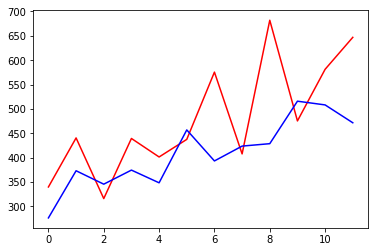

In [48]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:], color='red')
pyplot.plot(predictions, color='blue')
pyplot.show()

#Test RMSE: 154.670 when using fit_lstm(train_scaled, 1, 3000, 4)
#Test RMSE: 112.663 when using fit_lstm(train_scaled, 1, 1500, 1)

In [ ]:
pyplot.plot(predictions - raw_values[-12:])
pyplot.show()